# Recommend movies

## Background and Motivation

Recommendation system is widely used in our daily life, from shopping to entertainment. Here we are building a recommendation system for movies, based on:
- user's rating to movies
- user features: occupation, gender, age
- movie features: year, genre

## 1. set up Spark environment and read data

In [25]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [20]:
from sklearn.decomposition import NMF
import numpy as np
from sklearn.cluster import KMeans

In [1]:
import pyspark as ps
import pandas as pd
from pyspark.ml.recommendation import ALS
from datetime import datetime

spark = (
        ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("lecture") 
        .getOrCreate()
        )
sc = spark.sparkContext

request_data = pd.read_csv('data/requests.csv')
train_data = pd.read_csv('data/training.csv')
train_data['ts'] = train_data.timestamp.apply(lambda ts: datetime.fromtimestamp(ts))


df_f = spark.createDataFrame(train_data) 
df_re = spark.createDataFrame(request_data)


## 2. EDA

In [ ]:
pd.sca

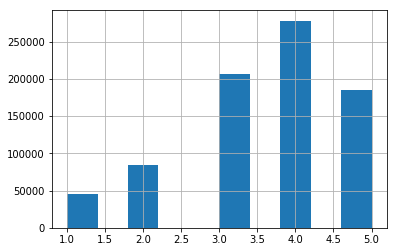

In [115]:
train_data.rating.hist()

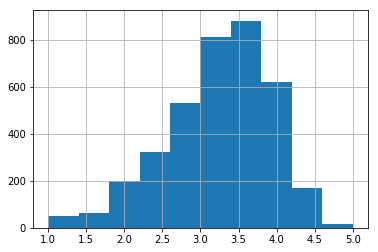

In [114]:
train_data.groupby('movie')['rating'].apply(np.mean).hist()

In [116]:
train_data.groupby('movie')['rating'].apply(lambda x:np.percentile(x,90,axis=0))

movie
1       5.0
2       4.0
3       4.0
4       4.0
5       4.0
6       5.0
7       5.0
8       4.0
9       4.0
10      5.0
11      5.0
12      4.0
13      4.5
14      5.0
15      4.0
16      5.0
17      5.0
18      5.0
19      4.0
20      4.0
21      5.0
22      4.8
23      4.0
24      4.0
25      5.0
26      5.0
27      4.0
28      5.0
29      5.0
30      5.0
       ... 
3923    4.0
3924    4.0
3925    5.0
3926    4.0
3927    5.0
3928    5.0
3929    5.0
3930    4.0
3931    3.1
3932    5.0
3933    4.0
3934    4.6
3935    4.0
3936    5.0
3937    4.0
3938    3.4
3939    4.0
3940    2.8
3941    4.0
3942    4.0
3943    4.0
3944    3.8
3945    2.5
3946    4.0
3947    5.0
3948    5.0
3949    5.0
3950    4.6
3951    5.0
3952    5.0
Name: rating, Length: 3662, dtype: float64

In [19]:
np.mean(train_data.ts > pd.to_datetime('2000-08-01'))

0.71464375

AttributeError: 'Figure' object has no attribute 'save'

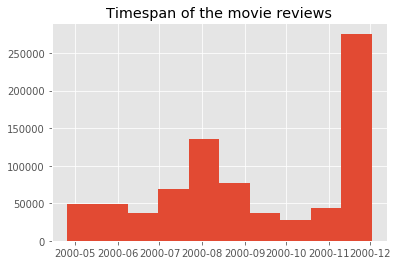

In [28]:
train_data.ts.dt.date.hist();
plt.title('Timespan of the movie reviews')

## 3. Models
### 3.1 ALS base model

In [36]:
als_model_f = ALS(
    itemCol='movie',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.2,
    rank=18) 
recommender_f = als_model_f.fit(df_f)
pred_request = recommender_f.transform(df_re)
pred_request_pd = pred_request.toPandas()

In [ ]:
pred_request_pd = prediction.toPandas() #convert to Pandas dataframe

In [ ]:
pre

### 3.2 ALS - grid search and cross validation

In [77]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
als = ALS()
pipeline = Pipeline(stages=[als])
paramGrid = ParamGridBuilder() \
    .addGrid(als.regParam, [0.1, 0.3]) \
    .addGrid(als.rank, [18,25]) \
    .build()

In [80]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=ClusteringEvaluator(),
                          numFolds=2)  # use 3+ folds in practice
cvModel = crossval.fit(df_f)
prediction = cvModel.transform(df_re)

IllegalArgumentException: 'Field "item" does not exist.'

### 3.3 Filling NANs

In [29]:
mask_NANs = pred_request_pd.prediction.isnull()

In [3]:
na_users = pred_request_pd[pred_request_pd.prediction.isnull()].user

In [5]:
dft = pd.DataFrame(na_users)

In [7]:
dft.to_csv('na_users.csv',index=False)

In [ ]:
user_mask = na_users.apply(lambda x: train_data.user == x) #True : new movie; False: new user

In [166]:
mask_NANs.value_counts()

False    104439
True      95770
Name: prediction, dtype: int64

In [ ]:
user_mask.value_counts()

In [169]:
53 in train_data.user

True

In [171]:
train_data.user == 53

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
799970    False
799971    False
799972    False
799973    False
799974    False
799975    False
799976    False
799977    False
799978    False
799979    False
799980    False
799981    False
799982    False
799983    False
799984    False
799985    False
799986    False
799987    False
799988    False
799989    False
799990    False
799991    False
799992    False
799993    False
799994    False
799995    False
799996    False
799997    False
799998    False
799999    False
Name: user, Length: 8000

In [94]:
import numpy as np
from sklearn.base import BaseEstimator,TransformerMixin
class ImputeNaNbythird(BaseEstimator, TransformerMixin):

    groupBy_colComp_colOn = [('movie', 'rating','prediction')]
#     ('Enclosure', 'near_price','near_price'),
#      ('ProductSize', 'near_price','near_price')]

    def fit(self, X):
        d = {}
        if self.groupBy_colComp_colOn:
            for groupby, col_comp, col_on in self.groupBy_colComp_colOn:
                d[groupby]=X.groupby(groupby)[col_comp].apply(np.mean).to_dict()
        self.d = d
        return self

    def transform(self, X):
        if self.groupBy_colComp_colOn:
            for groupby, col_comp, col_on in self.groupBy_colComp_colOn:
                X[col_on] = X[[groupby,col_on]].apply(lambda x: x[[col_on]].fillna(
                        self.d[groupby].get(x[groupby], np.nan)), axis=1)
        return X

In [95]:
I = ImputeNaNbythird()

In [96]:
m = I.fit(train_data)

In [105]:
len(m.d['movie'].keys())

3662

In [107]:
out2 = m.transform(pred_request_pd)

In [110]:
out2 = out2.rename(columns={'prediction':'rating'})
out2.to_csv('out2.csv',index=False)

## 4. User Clustering

In [15]:
users = pd.read_table('data/users.dat',sep='::',header=None)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [16]:
users['gender_M']=pd.get_dummies(users[1],drop_first=True)

In [17]:
users = users.rename(columns={0:'userid',2:'age',3:'occupation',4:'zipcode'})

In [18]:
users = users.drop(1,axis=1)

In [25]:
users = users.drop('zipcode', axis=1)

In [26]:
users.head(2)

,userid,age,occupation,gender_M
0,1,1,10,0
1,2,56,16,1


In [24]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
userid        6040 non-null int64
age           6040 non-null int64
occupation    6040 non-null int64
zipcode       6040 non-null object
gender_M      6040 non-null uint8
dtypes: int64(3), object(1), uint8(1)
memory usage: 194.7+ KB


### 4.1 Kmeans 

In [27]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(users.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [214]:
print(kmeans.cluster_centers_)

[[3.10912829e+01 8.26809211e+00 7.45888158e-01 7.38569079e+00
  4.21250000e+03]
 [3.06341667e+01 8.33166667e+00 7.27500000e-01 7.10250000e+00
  1.79650000e+03]
 [3.06548013e+01 8.29966887e+00 7.29304636e-01 7.38576159e+00
  3.00050000e+03]
 [3.04942623e+01 7.78442623e+00 6.63934426e-01 7.42459016e+00
  5.43050000e+03]
 [3.03168896e+01 8.05351171e+00 7.19063545e-01 7.21739130e+00
  5.98500000e+02]]


In [28]:
assigned_cluster = kmeans.transform(users.values).argmin(axis=1)

In [29]:
users['cluster'] = pd.Series(assigned_cluster)

In [30]:
rating_user = pd.merge(train_data,users,how='left',left_on='user',right_on='userid')

In [31]:
cluster_rating = rating_user.groupby(['cluster','movie']).mean()['rating']

In [33]:
cluster_rating.head(10)

cluster  movie
0        1        4.129730
         2        3.176471
         3        3.057851
         4        2.550000
         5        3.230769
         6        3.707317
         7        3.433333
         8        2.750000
         9        2.750000
         10       3.601399
Name: rating, dtype: float64

### 4.2 Fill in Nan with cluster average per movie

In [35]:
pred_user = pd.merge(pred_request_pd,users,how='left',left_on='user',right_on='userid')

NameError: name 'pred_request_pd' is not defined

In [34]:
pred_user.head(3)

NameError: name 'pred_user' is not defined

In [222]:
cluster_rating2 = rating_user.groupby(['cluster','movie']).mean()['rating'].reset_index()

In [223]:
merged = pd.merge(pred_user,cluster_rating2,how='left',left_on=['cluster','movie'],right_on=['cluster','movie'])

In [195]:
merged.head(3)

,user,movie,prediction,age,occupation,gender,cluster,userid,rating
0,53,148,NaN,25,0,1,7,53,2.5
1,4169,148,2.909497,50,0,1,2,4169,NaN
2,5333,148,2.361634,25,7,0,11,5333,3.0


In [224]:
merged['prediction_im1'] = merged.prediction.fillna(merged.rating)

In [225]:
merged['prediction_im2'] = merged.prediction_im1.fillna(0)

In [226]:
out_f = merged.iloc[:,[0,1,-1]]

In [227]:
out_f = out_f.rename(columns={'prediction_im2':'rating'})

In [228]:
out_f.to_csv('out_f.csv',index=False)

### NMF

In [125]:
nmf = NMF(n_components=18, random_state=1,alpha=.1, l1_ratio=.5)
U = nmf.fit(ratings_as_mat)
V = nmf.components_.T

In [124]:
U.dot(V.T)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.72454362e-01, 3.93312317e-02, 3.64783535e-02, ...,
        2.09112459e-04, 2.11591263e-03, 6.69626493e-03],
       [2.06950513e+00, 5.76532407e-01, 1.18310707e-01, ...,
        2.85711498e-02, 0.00000000e+00, 1.82449516e-03],
       [1.27747265e+00, 8.07680280e-02, 7.01429645e-03, ...,
        2.28096149e-02, 8.69379344e-02, 2.99992995e-01]])

In [126]:
nmf.transform()

ValueError: Array with wrong shape passed to NMF (input H). Expected (18, 2), but got (18, 3952) 

### Item-item similarity

In [55]:
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity



items_cos_sim, neighborhood = make_cos_sim_and_neighborhoods(users,10)

In [39]:
def make_cos_sim_and_neighborhoods(ratings_mat, neighborhood_size):
    '''
    Accepts a 2 dimensional matrix ratings_mat, and an integer neighborhood_size.
    Returns a tuple containing:
        - items_cos_sim, an item-item matrix where each element is the
        cosine_similarity of the items at the corresponding row and column. This
        is a square matrix where the length of each dimension equals the number
        of columns in ratings_mat.
        - neighborhood, a 2-dimensional matrix where each row is the neighborhood
        for that item. The elements are the indices of the n (neighborhood_size)
        most similar items. Most similar items are at the end of the row.
    '''
    items_cos_sim = cosine_similarity(ratings_mat.T)
    least_to_most_sim_indexes = np.argsort(items_cos_sim, 1)
    neighborhood = least_to_most_sim_indexes[:, -neighborhood_size:]
    return items_cos_sim, neighborhood

In [42]:
def pred_one_user(items_cos_sim, neighborhoods, ratings_mat, user_id):
    '''
    Returns the predicted ratings for all items for a given user.
    '''
    n_items = ratings_mat.shape[1]
    items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]
    # Just initializing so we have somewhere to put rating preds
    output = np.zeros(n_items)
    for item_to_rate in range(n_items):
        relevant_items = np.intersect1d(neighborhoods[item_to_rate],
                                        items_rated_by_this_user,
                                        assume_unique=True)
                                    # assume_unique speeds up intersection op
        # note: ratings_mat has data type `sparse_lil_matrix`, while
        # items_cos_sim is a numpy array. Luckily for us, multiplication
        # between these two classes is defined, and even more luckily,
        # it is defined to as the dot product. So the numerator
        # in the following expression is an array of a single float
        # (not an array of elementwise products as you would expect
        #  if both things were numpy arrays)
        output[item_to_rate] = (ratings_mat[user_id, relevant_items] * items_cos_sim[item_to_rate, relevant_items]/(items_cos_sim[item_to_rate, relevant_items].sum()))
    return output

In [43]:
def get_ratings_data(ratings_contents):
    '''
    Returns a tuple containing:
        - a dataframe of ratings
        - a sparse matrix where rows correspond to users and columns correspond
        to movies. Each element is the user's rating for that movie.
    '''
    highest_user_id = ratings_contents.user.max()
    highest_movie_id = ratings_contents.movie.max()
    ratings_as_mat = sparse.lil_matrix((highest_user_id, highest_movie_id))
    for _, row in ratings_contents.iterrows():
        # subtract 1 from id's due to match 0 indexing
        ratings_as_mat[row.user - 1, row.movie - 1] = row.rating
    return ratings_contents, ratings_as_mat


In [45]:
ratings_contents, ratings_as_mat = get_ratings_data(train_data)

In [57]:
pred_one_user(items_cos_sim,neighborhood,ratings_as_mat,216)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


IndexError: index 4 is out of bounds for axis 0 with size 4

In [53]:
neighborhood

array([[2, 3, 1, 0],
       [2, 3, 0, 1],
       [0, 3, 1, 2],
       [2, 0, 1, 3]])

In [51]:
na_users

0           53
5          216
6          482
8          424
11          26
12         319
13         202
15         331
16         524
20         392
21         516
22        1265
24         588
25          78
30         406
31         587
32          26
35         409
38         319
39         157
40         232
41         539
44         132
45         386
46         146
49         631
50         442
56         402
57         415
59         425
          ... 
200110     284
200111     566
200113     118
200115     475
200118      36
200119     393
200122     623
200126    1265
200133    1877
200135     225
200140     206
200141     442
200143     308
200162     229
200164     173
200166      59
200170     629
200171     136
200175     524
200178     361
200179     527
200184     390
200185     214
200188     195
200191     622
200192     151
200195     454
200197     131
200198     149
200202     281
Name: user, Length: 95770, dtype: int64

In [67]:
make_cos_sim_and_neighborhoods(users,10)

(array([[1.        , 0.74338555, 0.77826994],
        [0.74338555, 1.        , 0.71882111],
        [0.77826994, 0.71882111, 1.        ]]), array([[1, 2, 0],
        [2, 0, 1],
        [1, 0, 2]]))

In [71]:
items_cos_sim = cosine_similarity(users).shape

In [72]:
least_to_most_sim_indexes = np.argsort(items_cos_sim, 1)

AxisError: axis 1 is out of bounds for array of dimension 1